Epoch 1/10


C:\Users\abo__\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3593/3593 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0174 - val_loss: 1.3505e-04
Epoch 2/10
3593/3593 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1.2043e-04 - val_loss: 1.2749e-04
Epoch 3/10
3593/3593 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1.1843e-04 - val_loss: 1.2583e-04
Epoch 4/10
3593/3593 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1.1544e-04 - val_loss: 1.2574e-04
Epoch 5/10
3593/3593 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1.1346e-04 - val_loss: 1.2573e-04
Epoch 6/10
3593/3593 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1.1188e-04 - val_loss: 1.2574e-04
Epoch 7/10
3593/3593 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1.1054e-04 - val_loss: 1.2594e-04
Epoch 8/10
3593/3593 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1.0936e-04 - val_loss: 1.2651e-04
Epoch 9/10
3593/3593 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1.0839e-04 - val_loss: 1.2727e-04
Epoch 10/10
3593/3593 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 1.0747e-04 - val_loss: 1.2818e-04
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
61/61 ━━━━━━

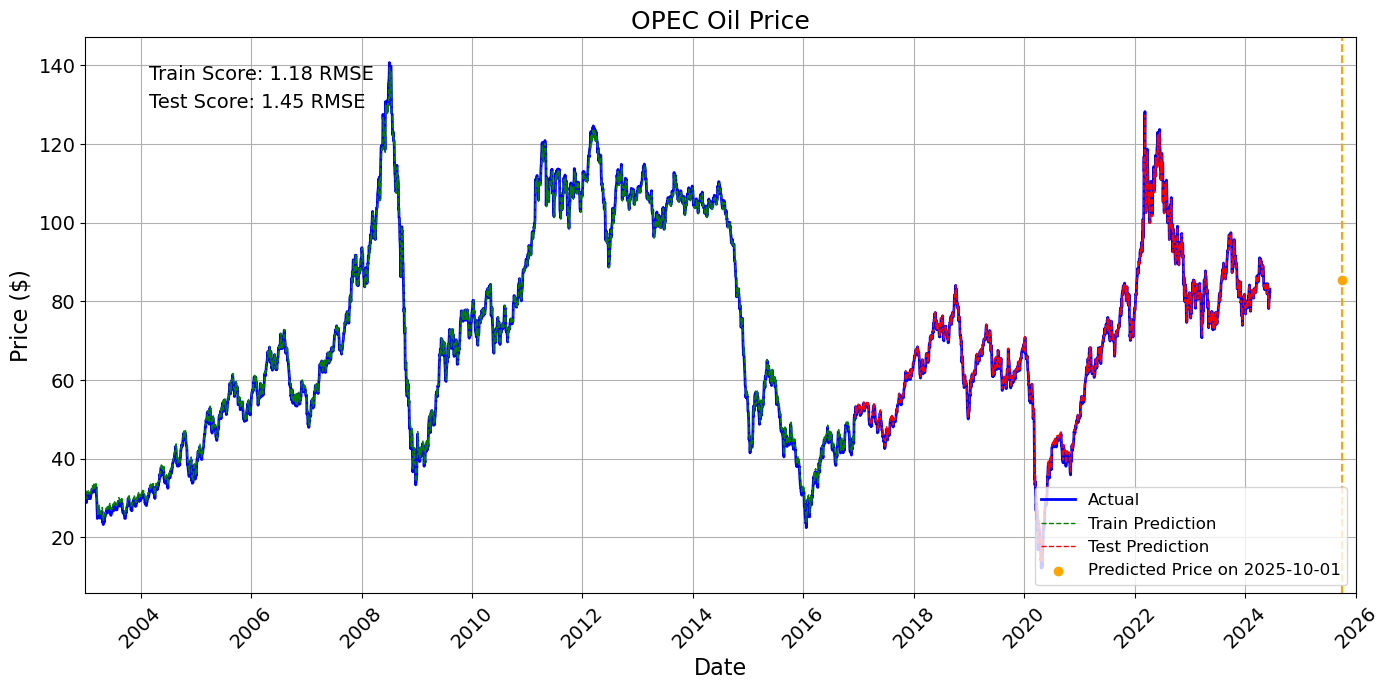

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import time

# Fix random seed for reproducibility
tf.random.set_seed(7)

# Load the dataset
dataframe = pd.read_csv('Oil.csv', usecols=[0, 1], engine='python')
dataset = dataframe.iloc[:, 1].values
dataset = dataset.astype('float32').reshape(-1, 1)

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Function to create dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Parameters
split = 0.65
lstm_units = 100
epochs = 10
look_back = 1

# Split the dataset
train_size = int(len(dataset) * split)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

# Create the dataset
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(lstm_units, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
start_time = time.time()
history = model.fit(trainX, trainY, epochs=epochs, batch_size=1, validation_data=(testX, testY), verbose=1)
end_time = time.time()
training_time = end_time - start_time

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY_inv = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_inv = scaler.inverse_transform([testY])

# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY_inv[0], trainPredict[:, 0]))
testScore = np.sqrt(mean_squared_error(testY_inv[0], testPredict[:, 0]))

print(f'Train Score: {trainScore:.2f} RMSE')
print(f'Test Score: {testScore:.2f} RMSE')
print(f'Training Time: {training_time:.2f} seconds')

# Extract the dates from the original dataframe
date_column = dataframe.columns[0]
dataframe[date_column] = pd.to_datetime(dataframe[date_column], format='%d/%m/%Y')
dates = dataframe[date_column].values

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2):len(trainPredict) + (look_back * 2) + len(testPredict), :] = testPredict

# Calculate business days between the last date in the dataset and 1/Oct/2025
last_date = dataframe[date_column].max()
future_date = pd.to_datetime('2025-10-01')

# Generate a range of business days
business_days = pd.bdate_range(start=last_date + pd.Timedelta(days=1), end=future_date)

# Predict the price on 1/Oct/2025
last_sequence = dataset[-look_back:]  # Start with the last 'look_back' values of the dataset

for _ in range(len(business_days)):
    last_sequence_reshaped = np.reshape(last_sequence, (1, 1, look_back))
    next_value = model.predict(last_sequence_reshaped)
    last_sequence = np.append(last_sequence[1:], next_value)

# Invert the final predicted value to the original scale
predicted_price = scaler.inverse_transform(next_value)

print(f"Predicted price on 1/Oct/2025: ${predicted_price[0, 0]:.2f}")

# Plot baseline and predictions
plt.figure(figsize=(14, 7))
plt.plot(dates, scaler.inverse_transform(dataset), label='Actual', color='blue', linewidth=2)
plt.plot(dates, trainPredictPlot, label='Train Prediction', color='green', linestyle='--',linewidth=1)
plt.plot(dates, testPredictPlot, label='Test Prediction', color='red', linestyle='--',linewidth=1)

# Add future prediction in orange
plt.scatter(future_date, predicted_price[0, 0], label='Predicted Price on 2025-10-01', color='orange', zorder=5)
plt.axvline(x=future_date, color='orange', linestyle='--')  # Add vertical dashed line

plt.xlabel('Date', fontsize=16)
plt.ylabel('Price ($)', fontsize=16)
plt.title('OPEC Oil Price', fontsize=18)

# Add train and test scores
plt.text(0.05, 0.95, f'Train Score: {trainScore:.2f} RMSE', transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top')
plt.text(0.05, 0.90, f'Test Score: {testScore:.2f} RMSE', transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top')

plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Extend the x-axis limit to 2026
start_date = pd.to_datetime('2003-01-01')  # Adjust this as per your dataset's starting date
end_date = pd.to_datetime('2026-01-01')    # Extend x-axis to include the year 2026
ax.set_xlim([start_date, end_date])

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('ThePREDCETION.png')

plt.show()
